In [1]:
import os
import cv2
import numpy as np
import absl.logging
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from pathlib import Path


# Mencoba untuk supress (menyembunyikan) log warning dari TensorFlow mediapipe
# Harapan: untuk membuat output lebih bersih tanpa log yang tidak berpengaruh
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['GLOG_minloglevel'] = '2'
absl.logging.set_verbosity(absl.logging.ERROR)


class FaceLandmark:

    BASE_ROOT_DIR = Path(os.getcwd()).parent

    BASE_MODEL_PATH = "src/face/tasks/face_landmarker.task"

    MODEL_PATH = Path(BASE_ROOT_DIR, BASE_MODEL_PATH)

    def __init__(self):

        # Jika file model tidak ditemukan, raise dengan sebuah error
        # untuk menghindari kesalahan saat inisialisasi model FaceLandmark
        if not self.MODEL_PATH.exists():
            raise FileNotFoundError(f"Model file not found at {self.MODEL_PATH}")

        # Inisialisasi base options dengan menyertakan path model yang benar
        self.base_options = python.BaseOptions(model_asset_path=self.MODEL_PATH.as_posix())

        # Inisialisasi options untuk FaceLandmarker
        # Beberapa parameter ditambahkan untuk konfigurasi yang lebih baik, seperti:
        # num_faces -> untuk menentukan jumlah wajah yang akan dideteksi
        # min_tracking_confidence -> untuk mengatur ambang kepercayaan pelacakan wajah
        # min_face_detection_confidence -> untuk mengatur ambang kepercayaan deteksi wajah
        # min_face_presence_confidence -> untuk mengatur ambang kepercayaan keberadaan wajah
        # running_mode -> untuk menentukan mode operasi (IMAGE, VIDEO, LIVE_STREAM)
        self.options = vision.FaceLandmarkerOptions(base_options=self.base_options,
                                                    num_faces=1,
                                                    min_tracking_confidence=0.7,
                                                    min_face_detection_confidence=0.7,
                                                    min_face_presence_confidence=0.7,
                                                    running_mode=vision.RunningMode.IMAGE)
        
        # Membuat instance Face Landmarker dengan opsi yang telah ditentukan
        self.landmarker = vision.FaceLandmarker.create_from_options(self.options)


    def detect(self, image: np.ndarray) -> vision.FaceLandmarkerResult: #type: ignore
        """
        Melakukan deteksi landmarks dengan citra input

        Args:
            image: Citra input dalam format numpy ndarray

        Returns:
            FaceLandmarkerResult: Hasil deteksi dari FaceLandmarker

        Raises:
            ValueError: Jika citra input tidak valid
        """

        # Jika citra bukan merupakan instance dari numpy ndarray
        # Maka raise dengan ValueError yang menunjukkan image harus berupa numpy ndarray
        if not isinstance(image, np.ndarray):
            raise ValueError("Input image must be a numpy ndarray.")

        # Jika citra tidak memiliki value apapun meskipun instance dari numpy ndarray
        # Maka raise dengan ValueError yang menunjukkan image tidak boleh kosong (invalid)
        if image.size == 0:
            raise ValueError("Input image is empty.")

        # Memastikan citra dalam format RGB sebelum diproses
        # Hal ini diperlukan oleh MediaPipe Face Landmarker
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_image)

        # Melakukan deteksi landmarks pada citra RGB
        return self.landmarker.detect(mp_image)

/home/inadio/skripkir/optical-flow/.venv/lib/python3.10/site-packages/numpy/_core/getlimits.py:558: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/inadio/skripkir/optical-flow/.venv/lib/python3.10/site-packages/numpy/_core/getlimits.py:90: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/inadio/skripkir/optical-flow/.venv/lib/python3.10/site-packages/numpy/_core/getlimits.py:558: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/inadio/skripkir/optical-flow/.venv/lib/python3.10/site-packages/numpy/_core/getlimits.py:90: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
import cv2


# Menargetkan pengujian deteksi landmark pada sebuah file video 
TARGET_FILE=os.path.join(Path.home(), "datasets", "primary-converted", "8-12-2025/aaisyah_nursalsabiil_ni_patriarti_1765168488512/q1/answer_1_15d591ce-051a-47f2-ac38-367c1e6189c7_sec.avi")

# Mengambil hanya satu frame untuk pengujian deteksi landmark
ret, frame = cv2.VideoCapture(TARGET_FILE).read()

# Instansiasi object FaceLandmark dan melakukan deteksi landmark pada frame
face_landmark   = FaceLandmark()
landmark_result = face_landmark.detect(frame)

W0000 00:00:1770010183.460502   79723 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1770010183.468659   79727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1770010183.484886   79741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [3]:
# Menampilkan jumlah titik landmark pada wajah yang terdeteksi pada frame
# menggunakan pendekatan FaceLandmarker dari MediaPipe Vision (latest v0.10.32).
print(len(landmark_result.face_landmarks[0]))

478


Hasil dari deteksi landmark menggunakan MediaPipe Vision yaitu sekitar 478 titik pada bagian wajah subjek.

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mediapipe.tasks.python.vision.face_landmarker import FaceLandmarksConnections 


class FaceLandmarkVisualizer:

    def __init__(self, landmark_result): #type: ignore
        if not hasattr(landmark_result, 'face_landmarks'):
            raise ValueError("landmark_result must have 'face_landmarks' attribute.")
        self.landmark_result = landmark_result


    def draw(self, image: np.ndarray, connections='tesselation') -> np.ndarray:
        """
        Menggambar titik landmark wajah pada input citra
        Args:
            image: Citra input dalam format numpy ndarray
            connections: 'tesselation' (full mesh) atau 'contours' (outline only)
        Returns:
            image: Citra output dengan titik landmark yang digambar
        Raises:
            ValueError: Jika citra input tidak valid
        """
        if not isinstance(image, np.ndarray):
            raise ValueError("Input image must be a numpy ndarray.")
        
        if image.size == 0:
            raise ValueError("Input image is empty.")
        
        if connections == 'contours':
            connection_set = FaceLandmarksConnections.FACE_LANDMARKS_CONTOURS
        else:
            connection_set = FaceLandmarksConnections.FACE_LANDMARKS_TESSELATION
        
        h, w, _ = image.shape
        
        # Menggambar koneksi dan titik landmark
        for normalized_landmark in self.landmark_result.face_landmarks:
            for connection in connection_set:

                # Menggunakan start dan end index dari koneksi untuk menggambar garis
                start_idx = connection.start
                end_idx = connection.end
                
                if start_idx < len(normalized_landmark) and end_idx < len(normalized_landmark):
                    start_point = normalized_landmark[start_idx]
                    end_point = normalized_landmark[end_idx]
                    
                    p1 = (int(start_point.x * w), int(start_point.y * h))
                    p2 = (int(end_point.x * w), int(end_point.y * h))
                    
                    cv2.line(image, p1, p2, (255, 0, 0), 1)
            
            for point in normalized_landmark:
                x_px = int(point.x * w)
                y_px = int(point.y * h)
                cv2.circle(image, (x_px, y_px), 1, (0, 255, 0), -1)
        
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

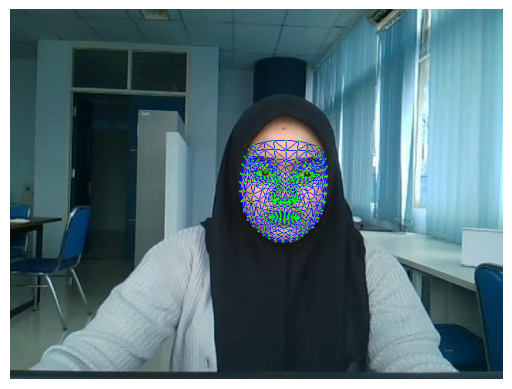

In [5]:
copied_face = frame.copy()

facial_landmark_visualizer = FaceLandmarkVisualizer(landmark_result=landmark_result)
facial_landmark_visualizer.draw(copied_face)

Memotong gambar berdasarkan facial landmark yang sudah didapatkan dari MediaPipe Vision

In [6]:
import numpy as np
from mediapipe.tasks.python.vision.face_landmarker import FaceLandmarkerResult


def crop(image: np.ndarray, landmark_result: FaceLandmarkerResult, margin: float = 0.2) -> np.ndarray: #type: ignore
    """
    Memotong wajah dari citra berdasarkan landmark yang terdeteksi

    Args:
        image: Citra input dalam format numpy ndarray
        landmark_result: Hasil deteksi dari FaceLandmarker
        margin: Margin tambahan di sekitar wajah (dalam rasio)

    Returns:
        cropped_face: Citra wajah yang telah dipotong

    Raises:
        ValueError: Jika citra input tidak valid atau tidak ada wajah yang terdeteksi
    """

    if not isinstance(image, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")

    if image.size == 0:
        raise ValueError("Input image is empty.")

    if not landmark_result.face_landmarks:
        raise ValueError("No face landmarks detected.")

    h, w, _ = image.shape

    # Mengambil landmark wajah pertama yang terdeteksi
    landmarks = landmark_result.face_landmarks[0]

    x_coords = [int(landmark.x * w) for landmark in landmarks]
    y_coords = [int(landmark.y * h) for landmark in landmarks]

    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Menambahkan margin
    x_margin = int((x_max - x_min) * margin)
    y_margin = int((y_max - y_min) * margin)

    x_min = max(0, x_min - x_margin)
    x_max = min(w, x_max + x_margin)
    y_min = max(0, y_min - y_margin)
    y_max = min(h, y_max + y_margin)

    cropped_face = image[y_min:y_max, x_min:x_max]

    return cropped_face

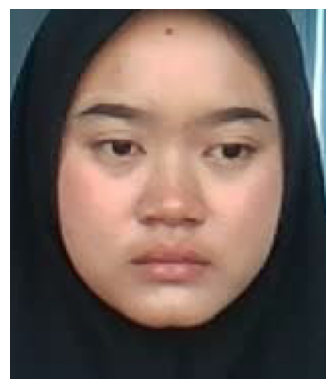

In [7]:
import matplotlib.pyplot as plt


copied_face = frame.copy()
cropped_face = crop(image=copied_face, landmark_result=landmark_result, margin=0.2)

plt.imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Memotong bagian wajah tertentu yang dianggap sebagai area paling dominan menunjukkan informasi dari ekspresi mikro

In [8]:
# Mendefinisikan point landmark untuk beberapa region of interest (RoI)
# Beberapa region of interest (RoI) pada wajah berdasarkan titik landmark
# didapatkan berdasarkan dokumentasi MediaPipe Face Mesh terkait facial connections
# 
# Referensi:
# https://github.com/google-ai-edge/mediapipe/blob/4cf89a70942ca3252e46ace7e4552f53be9bef2e/mediapipe/python/solutions/face_mesh_connections.py


LEFT_EYEBROW_POINTS = frozenset([(276, 283), (283, 282), (282, 295),
                                 (295, 285), (300, 293), (293, 334),
                                 (334, 296), (296, 336)])

RIGHT_EYEBROW_POINTS = frozenset([(46, 53), (53, 52), (52, 65), (65, 55),
                                  (70, 63), (63, 105), (105, 66), (66, 107)])

LEFT_EYE_POINTS = frozenset([(263, 249), (249, 390), (390, 373), (373, 374),
                             (374, 380), (380, 381), (381, 382), (382, 362),
                             (263, 466), (466, 388), (388, 387), (387, 386),
                             (386, 385), (385, 384), (384, 398), (398, 362)])

RIGHT_EYE_POINTS = frozenset([(33, 7), (7, 163), (163, 144), (144, 145),
                              (145, 153), (153, 154), (154, 155), (155, 133),
                              (33, 246), (246, 161), (161, 160), (160, 159),
                              (159, 158), (158, 157), (157, 173), (173, 133)])

LIPS_POINTS = frozenset([(61, 146), (146, 91), (91, 181), (181, 84), (84, 17),
                         (17, 314), (314, 405), (405, 321), (321, 375),
                         (375, 291), (61, 185), (185, 40), (40, 39), (39, 37),
                         (37, 0), (0, 267),
                         (267, 269), (269, 270), (270, 409), (409, 291),
                         (78, 95), (95, 88), (88, 178), (178, 87), (87, 14),
                         (14, 317), (317, 402), (402, 318), (318, 324),
                         (324, 308), (78, 191), (191, 80), (80, 81), (81, 82),
                         (82, 13), (13, 312), (312, 311), (311, 310),
                         (310, 415), (415, 308)])

In [ ]:
import cv2
import numpy as np
from typing import List, Tuple
from mediapipe.tasks.python.vision.face_landmarker import FaceLandmarkerResult


def crop_roi(image: np.ndarray, 
             landmark_result: FaceLandmarkerResult, #type: ignore
             roi_points: frozenset,
             margin: float = 0.05,
             target_size: Tuple[int, int] = (64, 64)) -> Tuple[np.ndarray, np.ndarray]:
    """
    Memotong bagian wajah berdasarkan region of interests (RoI) yang telah didefinisikan

    Args:
        image (np.ndarray): Citra input dalam format numpy ndarray
        landmark_result (FaceLandmarkerResult): Hasil deteksi landmark dari FaceLandmarker
        roi_points (frozenset): Koneksi titik landmark yang mendefinisikan RoI
        
    Returns:
        List[np.ndarray]: Daftar citra RoI yang telah dipotong
        
    Raises:
        ValueError: Jika citra input atau hasil deteksi landmark tidak valid
    """
    
    # Validasi citra input berupa numpy ndarray
    # Jika tidak, maka raise dengan ValueError
    if not isinstance(image, np.ndarray):
        raise ValueError("Input image must be a numpy ndarray.")
    
    # Validasi citra input tidak kosong
    # Jika kosong, maka raise dengan ValueError
    if image.size == 0:
        raise ValueError("Input image is empty.")
    
    # Validasi hasil deteksi landmark
    # Jika tidak ada hasil deteksi, maka raise dengan ValueError
    if landmark_result is None or not landmark_result.face_landmarks:
        raise ValueError("No face landmarks detected.")
    
    h, w = image.shape[:2]

    landmarks = landmark_result.face_landmarks[0]

    # Mengumpulkan semua indeks landmark yang terlibat dalam RoI
    roi_indices = set()
    for a, b in roi_points:
        roi_indices.add(a)
        roi_indices.add(b)

    # Menghitung bounding box dari landmark RoI
    xs = [landmarks[i].x * w for i in roi_indices]
    ys = [landmarks[i].y * h for i in roi_indices]

    # Menghitung koordinat bounding box untuk margin tambahan
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    # Menghitung tambahan margin tambahan untuk bounding box
    dx = (x_max - x_min) * margin
    dy = (y_max - y_min) * margin

    # Menghitung koordinat akhir bounding box dengan margin
    x1 = int(max(0, x_min - dx))
    y1 = int(max(0, y_min - dy))
    x2 = int(min(w, x_max + dx))
    y2 = int(min(h, y_max + dy))

    # Memotong citra berdasarkan bounding box yang dihitung
    roi = image[y1:y2, x1:x2]

    if roi.size == 0:
        raise ValueError("Empty ROI after cropping.")

    th, tw = target_size
    rh, rw = roi.shape[:2]

    # Menghitung skala untuk resizing sambil mempertahankan aspek rasio
    scale = min(tw / rw, th / rh)

    # Menghitung ukuran baru setelah scaling
    new_w = int(rw * scale)
    new_h = int(rh * scale)

    # Melakukan resizing pada RoI
    resized = cv2.resize(roi, (new_w, new_h))

    # Membuat citra output dengan ukuran target dan mengisi dengan nol (hitam)
    output = np.zeros((th, tw, 3), dtype=roi.dtype)
    x_off = (tw - new_w) // 2
    y_off = (th - new_h) // 2

    # Menempatkan citra yang telah di-resize ke dalam citra output di tengah
    output[y_off:y_off + new_h, x_off:x_off + new_w] = resized

    # Menghitung masking area
    mask = np.zeros((th, tw), dtype=np.uint8)

    # Menghitung polygon RoI pada citra output
    roi_polygon = []
    for i in roi_indices:
        px = landmarks[i].x * w - x1
        py = landmarks[i].y * h - y1

        px = px * scale + x_off
        py = py * scale + y_off

        roi_polygon.append([int(px), int(py)])

    # Mengisi polygon pada mask
    roi_polygon = np.array(roi_polygon, dtype=np.int32)
    cv2.fillConvexPoly(mask, roi_polygon, 255)

    return output, mask

In [35]:
from dataclasses import dataclass


@dataclass
class FaceRoiSizes:

    EYE_SIZE        = (16, 32)
    
    EYEBROW_SIZE    = (12, 24)
    
    LIPS_SIZE       = (32, 48)

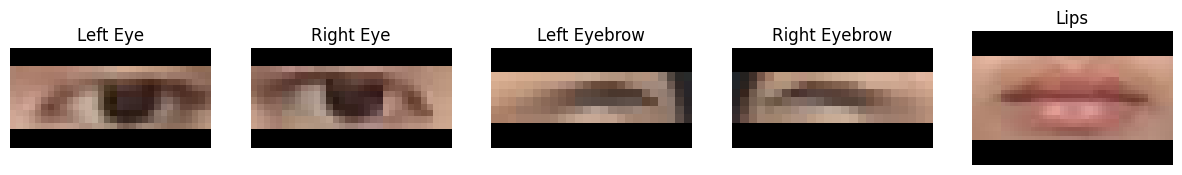

In [ ]:
cropped_left_eye        = crop_roi(image=frame, landmark_result=landmark_result, roi_points=LEFT_EYE_POINTS, margin=0.2, target_size=FaceRoiSizes.EYE_SIZE)
cropped_right_eye       = crop_roi(image=frame, landmark_result=landmark_result, roi_points=RIGHT_EYE_POINTS, margin=0.2, target_size=FaceRoiSizes.EYE_SIZE)
cropped_left_eyebrow    = crop_roi(image=frame, landmark_result=landmark_result, roi_points=LEFT_EYEBROW_POINTS, margin=0.2, target_size=FaceRoiSizes.EYEBROW_SIZE)
cropped_right_eyebrow   = crop_roi(image=frame, landmark_result=landmark_result, roi_points=RIGHT_EYEBROW_POINTS, margin=0.2, target_size=FaceRoiSizes.EYEBROW_SIZE)
cropped_lips            = crop_roi(image=frame, landmark_result=landmark_result, roi_points=LIPS_POINTS, margin=0.2, target_size=FaceRoiSizes.LIPS_SIZE)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(cv2.cvtColor(cropped_left_eye, cv2.COLOR_BGR2RGB))
axs[0].set_title("Left Eye")
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(cropped_right_eye, cv2.COLOR_BGR2RGB))
axs[1].set_title("Right Eye")
axs[1].axis('off')

axs[2].imshow(cv2.cvtColor(cropped_left_eyebrow, cv2.COLOR_BGR2RGB))
axs[2].set_title("Left Eyebrow")
axs[2].axis('off')

axs[3].imshow(cv2.cvtColor(cropped_right_eyebrow, cv2.COLOR_BGR2RGB))
axs[3].set_title("Right Eyebrow")
axs[3].axis('off')

axs[4].imshow(cv2.cvtColor(cropped_lips, cv2.COLOR_BGR2RGB))
axs[4].set_title("Lips")
axs[4].axis('off')

plt.show()